# Case 21.3 Tayko software cataloger

> (c) 2019 Galit Shmueli, Peter C. Bruce, Peter Gedeck 
>
> Case study included in
>
> _Data Mining for Business Analytics: Concepts, Techniques, and Applications in Python_ (First Edition) 
> Galit Shmueli, Peter C. Bruce, Peter Gedeck, and Nitin R. Patel. 2019.

In [1]:
%matplotlib inline

from pathlib import Path
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegressionCV
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from dmba import stepwise_selection, regressionSummary, gainsChart, AIC_score

DATA = Path('.').resolve().parent / 'data'

## Load the data

In [2]:
tayko_df = pd.read_csv(DATA / 'Tayko.csv')
print(tayko_df.shape)
tayko_df.head()

(2000, 25)


,sequence_number,US,source_a,source_c,source_b,source_d,source_e,source_m,source_o,source_h,...,source_x,source_w,Freq,last_update_days_ago,1st_update_days_ago,Web order,Gender=male,Address_is_res,Purchase,Spending
0,1,1,0,0,1,0,0,0,0,0,...,0,0,2,3662,3662,1,0,1,1,128
1,2,1,0,0,0,0,1,0,0,0,...,0,0,0,2900,2900,1,1,0,0,0
2,3,1,0,0,0,0,0,0,0,0,...,0,0,2,3883,3914,0,0,0,1,127
3,4,1,0,1,0,0,0,0,0,0,...,0,0,1,829,829,0,1,0,0,0
4,5,1,0,1,0,0,0,0,0,0,...,0,0,1,869,869,0,0,0,0,0


In [3]:
tayko_df.columns

Index(['sequence_number', 'US', 'source_a', 'source_c', 'source_b', 'source_d',
       'source_e', 'source_m', 'source_o', 'source_h', 'source_r', 'source_s',
       'source_t', 'source_u', 'source_p', 'source_x', 'source_w', 'Freq',
       'last_update_days_ago', '1st_update_days_ago', 'Web order',
       'Gender=male', 'Address_is_res', 'Purchase', 'Spending'],
      dtype='object')

# Assignment
## Step 1
Each catalog costs approximately $2 to mail (including printing, postage, and mailing costs). Estimate the gross profit that the firm could expect from the remaining 180,000 names if it selects them randomly from the pool.

In [4]:
# Calculate average spending from the 1,000 purchasers in the stratified sample
customersWithPurchase = tayko_df[tayko_df['Purchase'] == 1]
averageSpending = customersWithPurchase['Spending'].mean()
print('Average Spending', averageSpending)

# Expected average spending per customer
print('Expected average spending', 0.053 * averageSpending)

# Expected average profit per customer (remove cost of mailing)
print('Expected average profit', 0.053 * averageSpending - 2)

# Expected profit from remaining 180,000 names for random selection
print('Expected profit', 180000 * (0.053 * averageSpending - 2))

Average Spending 205.249
Expected average spending 10.878197
Expected average profit 8.878197
Expected profit 1598075.46


For a random selection, the company expects a profit of about 1.6 million USD

## Step 2
Develop a model for classifying a customer as a purchaser or nonpurchaser.

a. Partition the data randomly into a training set (800 records), validation set (700 records), and test set (500 records).

In [5]:
# alternative way using scikit-learn
train, temp = train_test_split(tayko_df, train_size=800, random_state=1)
valid, test = train_test_split(temp, train_size=700, random_state=1)

print('Training   : ', train.shape)
print('Validation : ', valid.shape)
print('Test : ', test.shape)

Training   :  (800, 25)
Validation :  (700, 25)
Test :  (500, 25)


b. Run logistic regression with L2 penalty, using method LogisticRegressionCV, to select the best subset of variables, then use this model to classify the data into purchasers and nonpurchasers. Use only the training set for running the model. (Logistic regression is used because it yields an estimated “probability of purchase,” which is required later in the analysis.)

In [6]:
predictors = list(tayko_df.columns)
outcome = 'Purchase'
predictors.remove(outcome)
predictors.remove('Spending')
predictors.remove('sequence_number')
print(predictors)

train_X = train[predictors]
train_y = train[outcome]
valid_X = valid[predictors]
valid_y = valid[outcome]

# scale = MinMaxScaler()
# train_X = scale.fit_transform(train_X)
model = LogisticRegressionCV(penalty="l2", solver='lbfgs', cv=5, max_iter=500)
model.fit(train_X, train_y)

print('regularization', model.C_)
print('intercept ', model.intercept_[0])
df = pd.DataFrame({
    'coeff': model.coef_[0], 
    'abs_coeff': np.abs(model.coef_[0])
}, index=predictors)
print(df.sort_values(by=['abs_coeff'], ascending=False))

['US', 'source_a', 'source_c', 'source_b', 'source_d', 'source_e', 'source_m', 'source_o', 'source_h', 'source_r', 'source_s', 'source_t', 'source_u', 'source_p', 'source_x', 'source_w', 'Freq', 'last_update_days_ago', '1st_update_days_ago', 'Web order', 'Gender=male', 'Address_is_res']
regularization [166.81005372]
intercept  -2.448368340536965
                         coeff  abs_coeff
source_h             -2.609225   2.609225
Freq                  1.924103   1.924103
source_a              1.205172   1.205172
source_u              1.194266   1.194266
source_c             -0.852761   0.852761
Web order             0.838118   0.838118
source_x              0.703198   0.703198
source_r              0.686858   0.686858
Address_is_res       -0.654618   0.654618
source_p              0.417491   0.417491
source_o             -0.406499   0.406499
Gender=male          -0.359065   0.359065
source_b             -0.337667   0.337667
source_s             -0.331861   0.331861
source_w              

In [7]:
def train_model(variables):
    if len(variables) == 0:
        return None
    model = LogisticRegressionCV(penalty="l2", solver='saga', cv=5, max_iter=5000)
    return model.fit(train_X[variables], train_y)

def score_model(model, variables):
    if len(variables) == 0:
        return 0
    logit_reg_valid = model.predict(valid_X[variables])
    return -accuracy_score(valid_y, [1 if p > 0.5 else 0 for p in logit_reg_valid])

logreg_model, best_variables = stepwise_selection(predictors, train_model, score_model, 
                                           direction='forward', verbose=True)
print(best_variables)
logreg_model_predictors = best_variables

Variables: US, source_a, source_c, source_b, source_d, source_e, source_m, source_o, source_h, source_r, source_s, source_t, source_u, source_p, source_x, source_w, Freq, last_update_days_ago, 1st_update_days_ago, Web order, Gender=male, Address_is_res
Start: score=0.00, constant
Step: score=-0.71, add Freq
Step: score=-0.77, add Web order
Step: score=-0.81, add source_h
Step: score=-0.82, add source_u
Step: score=-0.83, add source_c
Step: score=-0.84, add source_b
Step: score=-0.84, unchanged None
['Freq', 'Web order', 'source_h', 'source_u', 'source_c', 'source_b']


## Step 3
Develop a model for predicting spending among the purchasers.

a. Create subsets of the training and validation sets for only purchasers’ records by filtering for Purchase = 1.

In [8]:
purchaseIDs = list(tayko_df.loc[tayko_df.Purchase == 1].sequence_number)
len(purchaseIDs)

1000

b. Develop models for predicting spending with the filtered datasets, using:

    i. Multiple linear regression (use stepwise regression)
    ii. Regression trees

Choose one model on the basis of its performance on the validation data.

In [9]:
trainP = train.loc[train.Purchase == 1]
validP = valid.loc[valid.Purchase == 1]
testP = test.loc[test.Purchase == 1]

print('Training   : ', trainP.shape)
print('Validation : ', validP.shape)
print('Test : ', testP.shape)

Training   :  (389, 25)
Validation :  (361, 25)
Test :  (250, 25)


In [10]:
outcome = 'Spending'

train_X = trainP[predictors]
train_y = trainP[outcome]
valid_X = validP[predictors]
valid_y = validP[outcome]
test_X = testP[predictors]
test_y = testP[outcome]

# Linear regression model
def train_model(variables):
    if len(variables) == 0:
        return None
    model = LinearRegression()
    return model.fit(train_X[variables], train_y)

def score_model(model, variables):
    if len(variables) == 0:
        return mean_squared_error(train_y, [train_y.mean()] * len(train_y), model)
    return mean_squared_error(train_y, model.predict(train_X[variables]))


linear_model, best_variables = stepwise_selection(predictors, train_model, score_model, 
                                                  direction='stepwise', verbose=True)
print(best_variables)
linear_predictors = best_variables

Variables: US, source_a, source_c, source_b, source_d, source_e, source_m, source_o, source_h, source_r, source_s, source_t, source_u, source_p, source_x, source_w, Freq, last_update_days_ago, 1st_update_days_ago, Web order, Gender=male, Address_is_res
Start: score=54593.78, constant
Step: score=31171.49, add Freq
Step: score=29827.64, add Address_is_res
Step: score=28830.95, add last_update_days_ago
Step: score=28584.23, add source_e
Step: score=28477.11, add source_d
Step: score=28372.67, add source_p
Step: score=28286.78, add source_w
Step: score=28203.33, add source_t
Step: score=28136.43, add source_b
Step: score=28071.55, add Gender=male
Step: score=28010.85, add source_x
Step: score=27952.64, add source_h
Step: score=27902.76, add source_m
Step: score=27864.70, add source_r
Step: score=27834.74, add 1st_update_days_ago
Step: score=27815.09, add US
Step: score=27806.71, add source_o
Step: score=27800.61, add source_u
Step: score=27797.02, add source_c
Step: score=27794.33, add so

Validation performance

Regression statistics

                      Mean Error (ME) : -3.9070
       Root Mean Squared Error (RMSE) : 165.2843
            Mean Absolute Error (MAE) : 106.7053
          Mean Percentage Error (MPE) : -108.4046
Mean Absolute Percentage Error (MAPE) : 139.4048
Test performance

Regression statistics

                      Mean Error (ME) : -4.1470
       Root Mean Squared Error (RMSE) : 158.1129
            Mean Absolute Error (MAE) : 102.9828
          Mean Percentage Error (MPE) : -75.3418
Mean Absolute Percentage Error (MAPE) : 112.2414


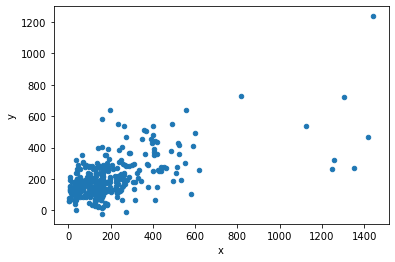

In [11]:
pd.DataFrame({'x': valid_y, 'y': linear_model.predict(valid_X[best_variables])}).plot.scatter(x='x', y='y')
print('Validation performance')
regressionSummary(valid_y, linear_model.predict(valid_X[best_variables]))
print('Test performance')
regressionSummary(test_y, linear_model.predict(test_X[best_variables]))

In [12]:
# regression tree
def train_model(variables):
    if len(variables) == 0:
        return None
    model = DecisionTreeRegressor()
    return model.fit(train_X[variables], train_y)

def score_model(model, variables):
    if len(variables) == 0:
        return mean_squared_error(train_y, [train_y.mean()] * len(train_y), model)
    return mean_squared_error(train_y, model.predict(train_X[variables]))

tree_model, best_variables = stepwise_selection(predictors, train_model, score_model, direction='forward', verbose=True)
print(best_variables)

Variables: US, source_a, source_c, source_b, source_d, source_e, source_m, source_o, source_h, source_r, source_s, source_t, source_u, source_p, source_x, source_w, Freq, last_update_days_ago, 1st_update_days_ago, Web order, Gender=male, Address_is_res
Start: score=54593.78, constant
Step: score=4390.71, add last_update_days_ago
Step: score=350.15, add 1st_update_days_ago
Step: score=29.11, add Web order
Step: score=7.53, add source_a
Step: score=0.00, add source_u
Step: score=0.00, unchanged None
['last_update_days_ago', '1st_update_days_ago', 'Web order', 'source_a', 'source_u']


Validation performance

Regression statistics

                      Mean Error (ME) : 4.5152
       Root Mean Squared Error (RMSE) : 249.2594
            Mean Absolute Error (MAE) : 148.6371
          Mean Percentage Error (MPE) : -98.8897
Mean Absolute Percentage Error (MAPE) : 150.5093
Test performance

Regression statistics

                      Mean Error (ME) : 4.8760
       Root Mean Squared Error (RMSE) : 252.7220
            Mean Absolute Error (MAE) : 146.3480
          Mean Percentage Error (MPE) : -101.7217
Mean Absolute Percentage Error (MAPE) : 152.5564


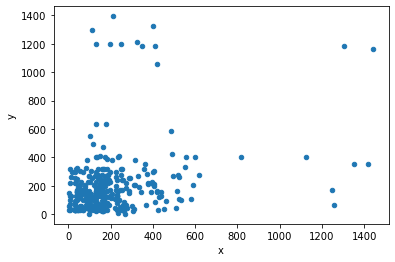

In [13]:
pd.DataFrame({'x': valid_y, 'y': tree_model.predict(valid_X[best_variables])}).plot.scatter(x='x', y='y')
print('Validation performance')
regressionSummary(valid_y, tree_model.predict(valid_X[best_variables]))
print('Test performance')
regressionSummary(test_y, tree_model.predict(test_X[best_variables]))

Based on the validation set performance (mean absolute errors), we select the linear regression model.

## Step 4
Return to the original test data partition. Note that this test data partition includes both purchasers and nonpurchasers. Create a new data frame called _Score Analysis_ that contains the test data portion of this dataset.

a. Add a column to the data frame with the predicted scores from the logistic regression.

b. Add another column with the predicted spending amount from the prediction model chosen.

c. Add a column for “adjusted probability of purchase” by multiplying “predicted probability of purchase” by 0.107. _This is to adjust for oversampling the purchasers_ (see earlier description).

d. Add a column for expected spending: adjusted probability of purchase × predicted spending.

e. Plot the cumulative gains chart of the expected spending (cumulative expected spending as a function of number of records targeted).

f. Using this cumulative gains curve, estimate the gross profit that would result from mailing to the 180,000 names on the basis of your data mining models.

In [14]:
scoreAnalysis = test.copy()
scoreAnalysis['purchaseProbability'] = logreg_model.predict_proba(test[logreg_model_predictors])[:,1]
scoreAnalysis['spendingPrediction'] = linear_model.predict(test[linear_predictors])
scoreAnalysis['adjustedSpendingPrediction'] = 0.107 * scoreAnalysis['spendingPrediction']
scoreAnalysis['expectedSpending'] = scoreAnalysis['purchaseProbability'] * scoreAnalysis['adjustedSpendingPrediction']

scoreAnalysis

,sequence_number,US,source_a,source_c,source_b,source_d,source_e,source_m,source_o,source_h,...,1st_update_days_ago,Web order,Gender=male,Address_is_res,Purchase,Spending,purchaseProbability,spendingPrediction,adjustedSpendingPrediction,expectedSpending
159,160,1,1,0,0,0,0,0,0,0,...,2369,0,1,0,1,547,0.964127,298.592482,31.949396,30.803279
703,704,1,0,0,0,0,0,0,0,0,...,609,0,1,0,1,162,0.545787,157.398579,16.841648,9.191953
320,321,0,1,0,0,0,0,0,0,0,...,3975,0,0,1,1,189,0.780768,133.866369,14.323701,11.183488
382,383,1,0,0,0,0,0,0,0,0,...,3401,0,0,0,0,0,0.058854,-2.046334,-0.218958,-0.012887
830,831,1,0,0,0,0,1,0,0,0,...,930,0,1,1,0,0,0.320615,12.708986,1.359862,0.435992
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1768,1769,1,0,1,0,0,0,0,0,0,...,896,0,0,0,0,0,0.018396,84.526167,9.044300,0.166375
1899,1900,1,0,0,0,1,0,0,0,0,...,3684,0,1,0,1,122,0.964127,226.841087,24.271996,23.401290
654,655,1,0,0,0,0,0,0,0,0,...,4096,0,1,0,0,0,0.058854,-30.114153,-3.222214,-0.189640
1676,1677,1,0,0,0,0,0,1,0,0,...,260,0,0,0,1,148,0.320615,122.622604,13.120619,4.206669


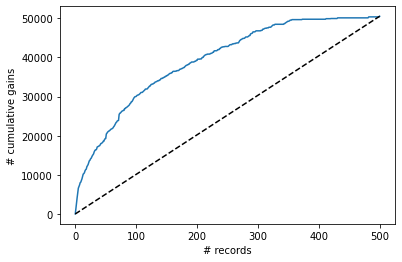

In [15]:
full_result = scoreAnalysis.sort_values(by=['expectedSpending'], ascending=False)
gainsChart(full_result.Spending)


In [16]:
# Calculate average spending based on the model
averageSpending = scoreAnalysis['expectedSpending'].mean()
print('Average expected spending', averageSpending)

# Expected profit from remaining 180,000 names for random selection
print('Expected profit', 180000 * (averageSpending - 2))

Average expected spending 10.337972408788579
Expected profit 1500835.0335819442
